In [1]:
import os
import sys
import pandas as pd
import yaml 
from matplotlib import pyplot as plt
from matplotlib import ticker as mticker
import statsmodels.api as sm
import numpy as np
from itertools import product
import subprocess

with open("../../config.yaml.local", "r") as f:
    LOCAL_CONFIG = yaml.safe_load(f)
#with open("../../config.yaml", "r") as f:
#    CONFIG = yaml.safe_load(f)
sys.path.append("../python")

import globals
import data_tools as dt

LOCAL_PATH = LOCAL_CONFIG["LOCAL_PATH"]
RAW_DATA_PATH = LOCAL_CONFIG["RAW_DATA_PATH"]
DATA_PATH = LOCAL_CONFIG["DATA_PATH"]
R_PATH = LOCAL_CONFIG["R_PATH"]

RUN_R_SCRIPTS = False


In [2]:
df = dt.get_user_by_week_panel(overwrite=True)
weekly_prices = dt.get_price_weekly()


c:\Users\edwar\projects\sn-research\src\notebooks\../python\data_tools.py:55: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  return x.dt.to_period('W-SAT').dt.start_time
c:\Users\edwar\projects\sn-research\src\notebooks\../python\data_tools.py:55: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  return x.dt.to_period('W-SAT').dt.start_time
c:\Users\edwar\projects\sn-research\src\notebooks\../python\data_tools.py:562: UserWarning: Converting to Period representation will drop timezone information.
  week_start = globals.data_start.to_period('W-SAT').start_time
c:\Users\edwar\projects\sn-research\src\notebooks\../python\data_tools.py:563: UserWarning: Converting to Period representation will drop timezone information.
  week_end = globals.data_end.to_period('W-SAT').start_time
c:\Users\edwar\projects\sn-research\src\notebooks\../python\data_tools.py:55: UserWarning: Converting to PeriodArray/Index

In [3]:
weekly_prices['wow_growth'] = np.log(weekly_prices['btc_price']) - np.log(weekly_prices['btc_price'].shift(1))
weekly_prices['mom_growth'] = np.log(weekly_prices['btc_price']) - np.log(weekly_prices['btc_price'].shift(4))
weekly_prices['yoy_growth'] = np.log(weekly_prices['btc_price']) - np.log(weekly_prices['btc_price'].shift(52))

In [4]:
# merge on weekly prices
df = df.merge(weekly_prices, on='week', how='left')

# remove SN employees
df = df.loc[~df['userId'].isin(globals.sn_employee_ids)].reset_index(drop=True)

# remove anon
df = df.loc[df['userId'] != globals.anon_id].reset_index(drop=True)

# output
df.to_csv(os.path.join(DATA_PATH, "user_analysis_data.csv"), index=False)

In [5]:
res = subprocess.run([R_PATH, LOCAL_PATH + "/src/R/playground.R"], check=True, capture_output=True, text=True)
print(res.stdout)


                               Dependent variable:        
                       -----------------------------------
                                 became_inactive          
                           (1)         (2)         (3)    
----------------------------------------------------------
unprofitable            0.900***    0.901***    0.875***  
                         (0.024)     (0.024)     (0.025)  
                                                          
pgrowth                              -0.036     -0.197**  
                                     (0.084)     (0.099)  
                                                          
unprofitable_X_pgrowth                          0.573***  
                                                 (0.185)  
                                                          
Constant                -2.499***   -2.498***   -2.492*** 
                         (0.013)     (0.014)     (0.014)  
                                                       

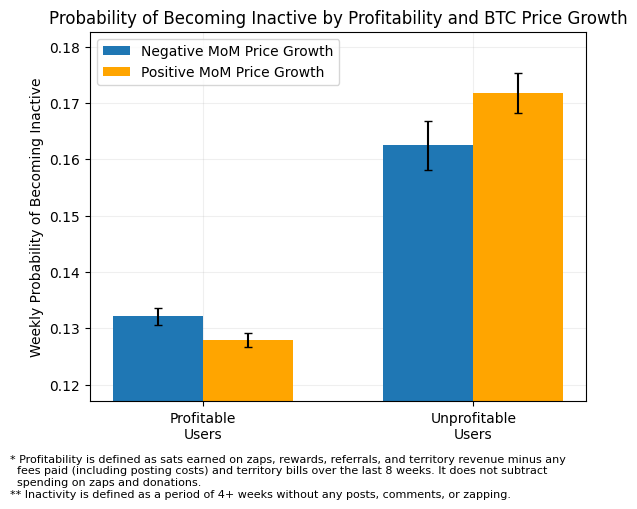

In [6]:
# plot

df['inactive'] = (df['weeks_since_last_activity']>=1) & (df['length_of_inactivity']>=4)
df['became_inactive'] = (df['weeks_since_last_activity']==1) & (df['length_of_inactivity']>=4)
df['unprofitable'] = (df['rolling_profit1']<0)
df['log_rolling_profit1'] = np.sign(df['rolling_profit1']) * np.log10(1+np.abs(df['rolling_profit1']))
df['pos_growth'] = df['mom_growth'] > 0

mask = (~df['inactive']) | (df['became_inactive'])

agg = df.loc[mask].groupby(['unprofitable', 'pos_growth']).agg(
    mean = ('became_inactive', 'mean'),
    count = ('userId', 'count'),
    became_inactive_std = ('became_inactive', 'std')
).reset_index()
agg['se'] = agg['became_inactive_std'] / np.sqrt(agg['count'])

means = agg.pivot(index='unprofitable', columns='pos_growth', values='mean')
ses = agg.pivot(index='unprofitable', columns='pos_growth', values='se')

plt.bar(0, means.loc[False,False], width=0.5, color='tab:blue', label='Negative MoM Price Growth', yerr=ses.loc[False,False], capsize=3)
plt.bar(0.5, means.loc[False,True], width=0.5, color='orange', label='Positive MoM Price Growth', yerr=ses.loc[False,True], capsize=3)
plt.bar(1.5, means.loc[True,False], width=0.5, color='tab:blue', yerr=ses.iloc[1,0], capsize=3)
plt.bar(2.0, means.loc[True,True], width=0.5, color='orange', yerr=ses.iloc[1,1], capsize=3)
ypad = (agg['mean'].max() - agg['mean'].min())/4
plt.ylim([agg['mean'].min()-ypad, agg['mean'].max()+ypad])
plt.grid(alpha=0.2)
plt.xticks([0.25, 1.75], ['Profitable\nUsers', 'Unprofitable\nUsers'])
plt.ylabel('Weekly Probability of Becoming Inactive')
plt.legend()
plt.title("Probability of Becoming Inactive by Profitability and BTC Price Growth")
plt.gca().set_axisbelow(True)
plt.figtext(0.0, 0.0, "* Profitability is defined as sats earned on zaps, rewards, referrals, and territory revenue minus any\n  fees paid (including posting costs) and territory bills over the last 8 weeks. It does not subtract\n  spending on zaps and donations.\n** Inactivity is defined as a period of 4+ weeks without any posts, comments, or zapping.", ha="left", va="top", fontsize=8)
plt.show()


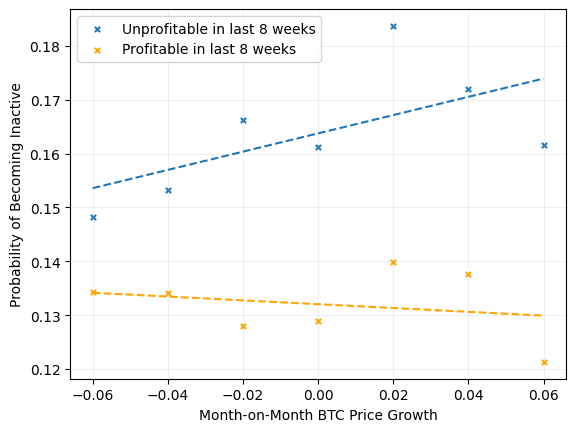

In [7]:
def kreg(x, y, bw, at):
    y_pred = np.zeros(len(at))
    for i, xi in enumerate(at):
        weights = np.exp(-0.5 * ((x - xi) / bw) ** 2)
        weights /= weights.sum()
        y_pred[i] = np.sum(weights * y)
    return y_pred

def means(x, y, bw, at):
    y_pred = np.zeros(len(at))
    for i, xi in enumerate(at):
        mask = (x >= xi - bw) & (x < xi + bw)
        y_pred[i] = y.loc[mask].mean()
    return y_pred

x = np.arange(-0.06, 0.061, 0.02)
bw = 0.01
yhat0 = means(
    x = df.loc[mask & (df['unprofitable']), 'mom_growth'],
    y = df.loc[mask & (df['unprofitable']), 'became_inactive'],
    bw = bw,
    at = x
)
m0, b0 = np.polyfit(x, yhat0, 1)

yhat1 = means(
    x = df.loc[mask & (~df['unprofitable']), 'mom_growth'],
    y = df.loc[mask & (~df['unprofitable']), 'became_inactive'],
    bw = bw,
    at = x
)
m1, b1 = np.polyfit(x, yhat1, 1)

#x = np.sign(logx) * (10**(np.abs(logx))-1)
plt.scatter(x, yhat0, color='tab:blue', label='Unprofitable in last 8 weeks', marker='x', s=14)
plt.plot(x, m0*x + b0, color='tab:blue', linestyle='--')
plt.scatter(x, yhat1, color='orange', label='Profitable in last 8 weeks', marker='x', s=14)
plt.plot(x, m1*x + b1, color='orange', linestyle='--')
#plt.xscale('symlog', linthresh=1)
plt.ylabel('Probability of Becoming Inactive')
plt.xlabel('Month-on-Month BTC Price Growth')
plt.grid(alpha=0.2)

plt.legend()
plt.show()

In [ ]:
def logitprob(b, x):
    xb = np.dot(x, b)
    return 1 / (1 + np.exp(-xb))

b = np.array([-2.498, 0.901])
x0 = np.array([1, 0])
x1 = np.array([1, 1])
logitprob(b, x1) - logitprob(b, x0)


0.092402817536353

In [15]:
b = np.array([-2.492, 0.875, -0.197, 0.573])
x0 = np.array([1, 0, 0, 0])
x1 = np.array([1, 1, 0, 0])
logitprob(b, x1) - logitprob(b, x0)

0.0891981063198117

In [16]:
b = np.array([-2.492, 0.875, -0.197, 0.573])
x0 = np.array([1, 0, 0.05, 0])
x1 = np.array([1, 1, 0.05, 0.05])
logitprob(b, x1) - logitprob(b, x0)

0.09250475019578484

In [19]:
0.049 + 0.073*0.05

0.05265